In [1]:
# --- Imports ---
import os
from pathlib import Path

import torch
from torch import nn
import numpy as np

from transformers import CLIPModel, CLIPProcessor

print("PyTorch:", torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


PyTorch: 2.9.0+cu128
Using device: cuda


### Step 1 — Load and freeze CLIP

In [2]:
MODEL_NAME = "openai/clip-vit-base-patch32"  # good default

clip_model = CLIPModel.from_pretrained(MODEL_NAME)
clip_processor = CLIPProcessor.from_pretrained(MODEL_NAME, use_fast=True)

In [3]:
clip_model.to(device)
clip_model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [4]:
# Freeze parameters
for p in clip_model.parameters():
    p.requires_grad = False

In [5]:
# Count parameters
sum_params = sum(p.numel() for p in clip_model.parameters())
sum_trainable = sum(p.numel() for p in clip_model.parameters() if p.requires_grad)
print(f"Total params: {sum_params:,}")
print(f"Trainable params: {sum_trainable:,}")

Total params: 151,277,313
Trainable params: 0


### Load the PixMo dataset for alignment 

In [6]:
from datasets import load_dataset
pixmo_ds = load_dataset("allenai/pixmo-cap", split="all")
print(pixmo_ds)
print(pixmo_ds[0])


Dataset({
    features: ['image_url', 'caption', 'transcripts'],
    num_rows: 717042
})
{'image_url': 'https://pixmo.s3.us-west-2.amazonaws.com/birds/1491.png', 'caption': "This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall with red stains. The bird's sleek, elongated body is adorned with iridescent feathers that shimmer with shades of blue, purple, and green, most prominently on its wings and back. Its piercing yellow eye and long, sharp beak lend it a fierce, almost aerodynamic appearance. The bird's dark, slender legs and short talons grip the edge of the cement structure, which resembles a divider or barrier, possibly in an outdoor setting like a park or building patio. The background is a blur of green and white hues, hinting at lush tropical plants and tall trees, setting a serene, natural scene. The bird is poised, looking towards the upper right-hand corner of the frame, with its long tail feathers trailing eleg

#### Since Pixmo is image URL's, we first fetch the images in an array to load them 

In [7]:
import requests
from PIL import Image
from io import BytesIO
from multiprocessing import Pool, cpu_count


# ------------------------------------------------------------
# Fetch one image from URL
# ------------------------------------------------------------
def fetch_image(url: str) -> Image.Image:
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    img = Image.open(BytesIO(resp.content)).convert("RGB")
    return img


In [8]:
# Build a small working subset (e.g., first 16)
N_EXAMPLES = 500
subset = pixmo_ds.select(range(N_EXAMPLES))

In [9]:


# ------------------------------------------------------------
# Worker for multiprocessing
# ------------------------------------------------------------
def _fetch_single(args):
    idx, ex = args
    url = ex["image_url"]
    cap = ex["caption"]
    try:
        img = fetch_image(url)
        return idx, img, cap, None
    except Exception as e:
        return idx, None, None, e


# ------------------------------------------------------------
# Parallel image–caption collector
# ------------------------------------------------------------
def collect_image_caption_pairs_mp(subset, processes=None):
    processes = processes or min(8, cpu_count())

    images = []
    captions = []

    # prepare input as (idx, example) pairs
    tasks = [(i, ex) for i, ex in enumerate(subset)]

    with Pool(processes=processes) as pool:
        for idx, img, cap, err in pool.imap_unordered(_fetch_single, tasks):
            print("Fetched index", idx)
            if err:
                print(f"Skipping index {idx} due to error: {err}")
                continue
            images.append(img)
            captions.append(cap)

    print("Collected", len(images), "image-caption pairs")
    return images, captions


In [10]:
images, captions = collect_image_caption_pairs_mp(subset)

Fetched index 1
Fetched index 7
Fetched index 4
Fetched index 3
Fetched index 8
Fetched index 10
Fetched index 2
Fetched index 9
Fetched index 12
Skipping index 12 due to error: 429 Client Error: Unknown Error for url: http://i.imgur.com/mckPIFW.jpg?1
Fetched index 13
Skipping index 13 due to error: 429 Client Error: Unknown Error for url: https://i.imgur.com/2g6Y6D4.jpg
Fetched index 11
Fetched index 15
Fetched index 16
Fetched index 17
Fetched index 0
Fetched index 20
Fetched index 14
Fetched index 5
Fetched index 6
Fetched index 19
Fetched index 22
Fetched index 25
Skipping index 25 due to error: 429 Client Error: Unknown Error for url: http://i.imgur.com/RXvUtIx.jpg
Fetched index 23
Fetched index 29
Fetched index 28
Skipping index 28 due to error: 530 Server Error: <none> for url: https://assets.uigarage.net/content/uploads/2019/02/IMG_3043-1-576x1024.png
Fetched index 24
Fetched index 27
Fetched index 31
Skipping index 31 due to error: 429 Client Error: Unknown Error for url: http

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Fetched index 298
Fetched index 294
Fetched index 300
Fetched index 299
Fetched index 301
Fetched index 303
Fetched index 286
Fetched index 302
Fetched index 306
Fetched index 308
Fetched index 305
Fetched index 311
Fetched index 312
Fetched index 310
Fetched index 309
Fetched index 313
Fetched index 307
Fetched index 317
Fetched index 315
Fetched index 314
Fetched index 316
Fetched index 319
Fetched index 318
Fetched index 245
Fetched index 320
Fetched index 322
Fetched index 324
Fetched index 325
Fetched index 326
Fetched index 327
Fetched index 323
Fetched index 328
Fetched index 333
Skipping index 333 due to error: 429 Client Error: Unknown Error for url: http://i.imgur.com/GMzA2LY.jpg
Fetched index 331
Skipping index 331 due to error: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))
Fetched index 332
Fetched index 335
Fetched index 334
Fetched index 329
Fetched index 338
Fetched index 337
Fetched index 339
Fetched index 342
Fetched index 341
Fetched i

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Fetched index 383
Fetched index 381
Fetched index 385
Fetched index 386
Fetched index 388
Fetched index 384
Fetched index 387
Fetched index 391
Fetched index 390
Fetched index 392
Fetched index 389
Fetched index 373
Fetched index 393
Fetched index 394
Skipping index 394 due to error: 403 Client Error: Forbidden for url: https://ih1.redbubble.net/image.5244244233.8904/flat,750x,075,f-pad,750x1000,f8f8f8.jpg
Fetched index 396
Fetched index 397
Fetched index 400
Fetched index 401
Skipping index 401 due to error: broken data stream when reading image file
Fetched index 402
Fetched index 403
Fetched index 395
Fetched index 404
Fetched index 405
Skipping index 405 due to error: 404 Client Error: Not Found for url: https://img.youtube.com/vi/wwcRah-imPw/maxres1.jpg
Fetched index 360
Fetched index 407
Fetched index 408
Fetched index 398
Fetched index 409
Skipping index 409 due to error: 404 Client Error: Not Found for url: https://www.aaronstouchup.com/wp-content/uploads/2014/01/before-after-f

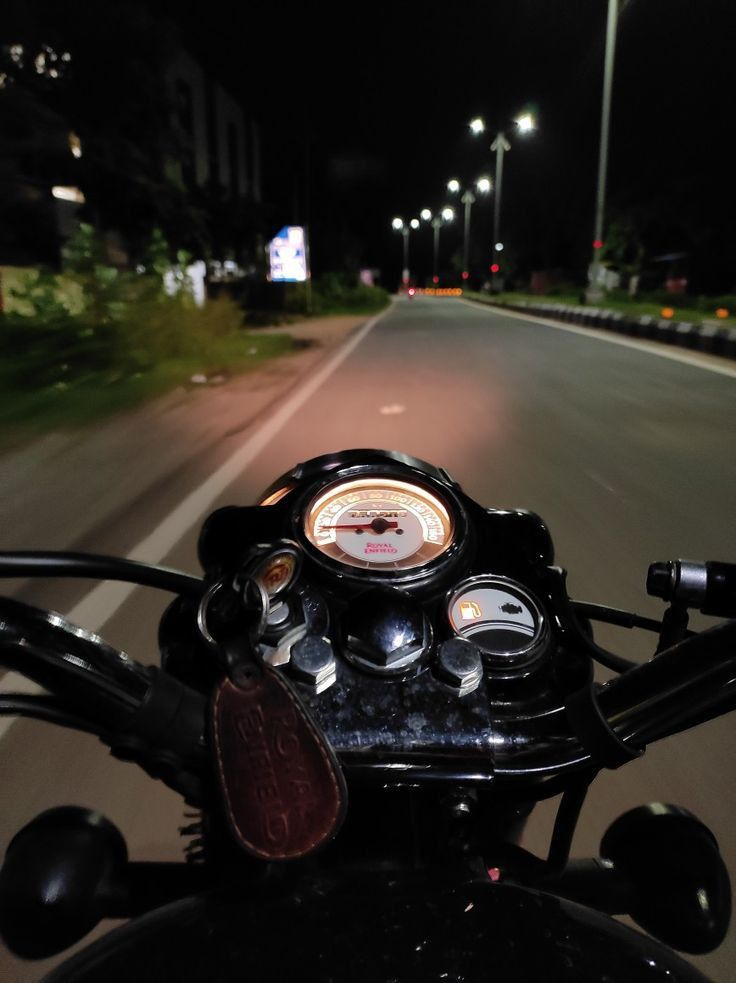

This nighttime image captures a dynamic point of view from a motorcycle rider on a dimly lit street, giving a sense of motion and speed. The viewer sees the motorcycle's handlebars and front dash, including a prominent circular speedometer and a smaller gas gauge, with a key inserted in the ignition, attached to a brown leather key holder. The handlebar details and top of the seat are slightly cut ...


In [11]:
from IPython.display import display

display(images[0])
print(captions[0][:400], "...")

### Encoding images wof Pixmo with CLIP

In [12]:
def encode_images_texts_from_pil(images, captions, batch_size=8):
    all_img_embs = []
    all_txt_embs = []

    for i in range(0, len(images), batch_size):
        batch_imgs = images[i:i+batch_size]
        batch_txts = captions[i:i+batch_size]

        inputs = clip_processor(
            text=batch_txts,
            images=batch_imgs,
            return_tensors="pt",
            padding=True,
            truncation=True,              # ✅ <--- this is the key
            max_length=77
        ).to(device)

        with torch.no_grad():
            outputs = clip_model(**inputs)
            img_emb = outputs.image_embeds       # (B, d)
            txt_emb = outputs.text_embeds        # (B, d)

        img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
        txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)

        all_img_embs.append(img_emb.cpu())
        all_txt_embs.append(txt_emb.cpu())

    all_img_embs = torch.cat(all_img_embs, dim=0)
    all_txt_embs = torch.cat(all_txt_embs, dim=0)

    return all_img_embs, all_txt_embs


In [13]:
img_emb, txt_emb = encode_images_texts_from_pil(images, captions, batch_size=8)
print("Image embeddings shape:", img_emb.shape)
print("Text embeddings shape :", txt_emb.shape)


Image embeddings shape: torch.Size([435, 512])
Text embeddings shape : torch.Size([435, 512])


### Similarity matrix + retrieval on PixMo

In [14]:
img_np = img_emb.numpy()
txt_np = txt_emb.numpy()

sim_matrix = img_np @ txt_np.T
print("Similarity matrix shape:", sim_matrix.shape)


Similarity matrix shape: (435, 435)


In [15]:
def top1_retrieval(sim_matrix, captions):
    N = sim_matrix.shape[0]
    correct = 0
    for i in range(N):
        j = sim_matrix[i].argmax()
        is_correct = (i == j)
        if is_correct:
            correct += 1
        print(f"Image {i}: best caption idx = {j} | correct={is_correct}")
        print("  GT caption (truncated):", captions[i][:120].replace("\n", " "), "...")
        print("  Top caption (truncated):", captions[j][:120].replace("\n", " "), "...")
        print()
    print(f"Top-1 accuracy (identity pairing): {correct}/{N} = {correct / N:.2f}")

top1_retrieval(sim_matrix, captions)


Image 0: best caption idx = 0 | correct=True
  GT caption (truncated): This nighttime image captures a dynamic point of view from a motorcycle rider on a dimly lit street, giving a sense of m ...
  Top caption (truncated): This nighttime image captures a dynamic point of view from a motorcycle rider on a dimly lit street, giving a sense of m ...

Image 1: best caption idx = 1 | correct=True
  GT caption (truncated): In the Barrett-Jackson corporate office, an extraordinary conference room captures the essence of automotive passion and ...
  Top caption (truncated): In the Barrett-Jackson corporate office, an extraordinary conference room captures the essence of automotive passion and ...

Image 2: best caption idx = 2 | correct=True
  GT caption (truncated): The image displays an illustration, possibly in a journal or textbook, showcasing a branch with green leaves and both ma ...
  Top caption (truncated): The image displays an illustration, possibly in a journal or textbook, showcasi

### Save PixMo embeddings for the projector step

In [16]:
SAVE_ROOT = Path("artifacts/clip_projector_poc_pixmo")
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

np.save(SAVE_ROOT / "img_emb.npy", img_np)
np.save(SAVE_ROOT / "txt_emb.npy", txt_np)

with open(SAVE_ROOT / "captions.txt", "w") as f:
    for cap in captions:
        f.write(cap.replace("\n", " ") + "\n")

print("Saved embeddings and captions to:", SAVE_ROOT)


Saved embeddings and captions to: artifacts/clip_projector_poc_pixmo


### Loading those saved embeddings

In [17]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

SAVE_ROOT = Path("artifacts/clip_projector_poc_pixmo")

img_np = np.load(SAVE_ROOT / "img_emb.npy")
txt_np = np.load(SAVE_ROOT / "txt_emb.npy")

print("Loaded shapes:", img_np.shape, txt_np.shape)


Loaded shapes: (435, 512) (435, 512)


In [18]:
img_tensor = torch.from_numpy(img_np).float()
txt_tensor = torch.from_numpy(txt_np).float()

print(img_tensor.shape, img_tensor.dtype)
print(txt_tensor.shape, txt_tensor.dtype)

dataset = TensorDataset(img_tensor, txt_tensor)


torch.Size([435, 512]) torch.float32
torch.Size([435, 512]) torch.float32


In [19]:
import torch.nn as nn

d_clip = img_tensor.shape[1]     # typically 512
d_proj = 1024                    # you can change this

class ProjectorMLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=None):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = out_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.net(x)

P_img = ProjectorMLP(d_clip, d_proj).to(device)
P_txt = ProjectorMLP(d_clip, d_proj).to(device)

sum_p_img = sum(p.numel() for p in P_img.parameters())
sum_p_txt = sum(p.numel() for p in P_txt.parameters())
print(f"P_img params: {sum_p_img:,}, P_txt params: {sum_p_txt:,}")


P_img params: 1,574,912, P_txt params: 1,574,912


In [20]:
import torch.nn.functional as F

def contrastive_loss(z_img, z_txt, temperature=0.07):
    """
    z_img, z_txt: (B, d_proj)
    Returns: scalar loss, img2txt_acc, txt2img_acc
    """
    # Normalize
    z_img = F.normalize(z_img, dim=-1)
    z_txt = F.normalize(z_txt, dim=-1)

    # Similarity matrix: (B, B)
    logits = z_img @ z_txt.T    # cosine sims
    logits = logits / temperature

    B = logits.shape[0]
    targets = torch.arange(B, device=logits.device)

    # Image -> text (rows over texts)
    loss_i2t = F.cross_entropy(logits, targets)

    # Text -> image (columns over images)
    loss_t2i = F.cross_entropy(logits.T, targets)

    loss = (loss_i2t + loss_t2i) / 2.0

    # Compute top-1 accuracy for monitoring
    with torch.no_grad():
        pred_i2t = logits.argmax(dim=1)
        pred_t2i = logits.argmax(dim=0)
        acc_i2t = (pred_i2t == targets).float().mean().item()
        acc_t2i = (pred_t2i == targets).float().mean().item()

    return loss, acc_i2t, acc_t2i


### Step 9 — DataLoader + optimizer

In [25]:
BATCH_SIZE = 64    # if your N_EXAMPLES is small, you can use 16 or 8
LR = 1e-3

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

optimizer = torch.optim.Adam(
    list(P_img.parameters()) + list(P_txt.parameters()),
    lr=LR,
    weight_decay=1e-4,
)


In [26]:
from tqdm.auto import tqdm

EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    P_img.train()
    P_txt.train()

    epoch_loss = 0.0
    epoch_acc_i2t = 0.0
    epoch_acc_t2i = 0.0
    n_batches = 0

    for img_batch, txt_batch in loader:
        img_batch = img_batch.to(device)
        txt_batch = txt_batch.to(device)

        optimizer.zero_grad()

        z_img = P_img(img_batch)      # (B, d_proj)
        z_txt = P_txt(txt_batch)      # (B, d_proj)

        loss, acc_i2t, acc_t2i = contrastive_loss(z_img, z_txt, temperature=0.07)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_i2t += acc_i2t
        epoch_acc_t2i += acc_t2i
        n_batches += 1

    print(
        f"Epoch {epoch:02d} | "
        f"loss={epoch_loss/n_batches:.4f} | "
        f"img→txt acc={epoch_acc_i2t/n_batches:.3f} | "
        f"txt→img acc={epoch_acc_t2i/n_batches:.3f}"
    )


Epoch 01 | loss=0.3020 | img→txt acc=0.932 | txt→img acc=0.917
Epoch 02 | loss=0.1698 | img→txt acc=0.964 | txt→img acc=0.982
Epoch 03 | loss=0.1441 | img→txt acc=0.961 | txt→img acc=0.982
Epoch 04 | loss=0.0911 | img→txt acc=0.997 | txt→img acc=0.995
Epoch 05 | loss=0.0642 | img→txt acc=1.000 | txt→img acc=0.997
Epoch 06 | loss=0.0505 | img→txt acc=1.000 | txt→img acc=1.000
Epoch 07 | loss=0.0430 | img→txt acc=1.000 | txt→img acc=1.000
Epoch 08 | loss=0.0371 | img→txt acc=1.000 | txt→img acc=0.997
Epoch 09 | loss=0.0395 | img→txt acc=0.997 | txt→img acc=0.997
Epoch 10 | loss=0.0381 | img→txt acc=1.000 | txt→img acc=1.000


In [27]:
P_img.eval()
P_txt.eval()

with torch.no_grad():
    all_img = img_tensor.to(device)
    all_txt = txt_tensor.to(device)

    z_img_all = P_img(all_img)
    z_txt_all = P_txt(all_txt)

    z_img_all = F.normalize(z_img_all, dim=-1)
    z_txt_all = F.normalize(z_txt_all, dim=-1)

sim_proj = (z_img_all @ z_txt_all.T).cpu().numpy()
print("Projected similarity matrix shape:", sim_proj.shape)


Projected similarity matrix shape: (435, 435)


In [28]:
# reload captions for readability
caps = []
with open(SAVE_ROOT / "captions.txt") as f:
    for line in f:
        caps.append(line.strip())

top1_retrieval(sim_proj, caps)


Image 0: best caption idx = 0 | correct=True
  GT caption (truncated): This nighttime image captures a dynamic point of view from a motorcycle rider on a dimly lit street, giving a sense of m ...
  Top caption (truncated): This nighttime image captures a dynamic point of view from a motorcycle rider on a dimly lit street, giving a sense of m ...

Image 1: best caption idx = 1 | correct=True
  GT caption (truncated): In the Barrett-Jackson corporate office, an extraordinary conference room captures the essence of automotive passion and ...
  Top caption (truncated): In the Barrett-Jackson corporate office, an extraordinary conference room captures the essence of automotive passion and ...

Image 2: best caption idx = 2 | correct=True
  GT caption (truncated): The image displays an illustration, possibly in a journal or textbook, showcasing a branch with green leaves and both ma ...
  Top caption (truncated): The image displays an illustration, possibly in a journal or textbook, showcasi